In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
def avg_return(history: pd.Series, timeperiod: int = 255) -> float:
    """
    #### Description:
    Calculate the average return of a financial instrument over a specified time period.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.
    - timeperiod (int, optional): The number of periods to consider for calculating the average return. Default is 255.

    #### Returns:
    - float: Average return over the specified time period.
    """
    returns = history.pct_change().dropna()
    return (1 + returns.sum()) ** (timeperiod/returns.count()) - 1

def avg_volatility(history: pd.Series, timeperiod: int = 255) -> float:
    """
    #### Description:
    Calculate the average volatility of a financial instrument over a specified time period.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.
    - timeperiod (int, optional): The number of periods to consider for calculating the average volatility. Default is 255.

    #### Returns:
    - float: Average volatility over the specified time period.
    """
    returns = history.pct_change(fill_method=None).dropna()
    volatility = np.std(returns, axis=0) * np.sqrt(timeperiod)
    return pd.to_numeric(volatility, errors='coerce')

def max_drawdown(history: pd.Series) -> float:
    """
    #### Description:
    Max Drawdown is a measure of the largest loss from a peak to a trough in a financial instrument's historical performance.
    It is calculated as the percentage decline relative to the highest cumulative value.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.

    #### Returns:
    - float: Maximum drawdown, representing the largest percentage decline from a peak to a trough.
    """
    # Calculate the cumulative percentage change in price or returns
    index = 100 * (1 + history.pct_change()).cumprod()

    # Identify the peaks and calculate drawdowns
    peaks = index.cummax()
    drawdowns = (index - peaks) / peaks

    # Return the maximum drawdown
    return drawdowns.min()


In [12]:
def gbm(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Simulate Geometric Brownian Motion trajectories for stock prices using Monte Carlo simulations.
    :param n_years: Number of years to simulate.
    :param n_scenarios: Number of scenarios/trajectories.
    :param mu: Annualized drift (expected return).
    :param sigma: Annualized volatility.
    :param steps_per_year: Granularity of the simulation (number of steps per year).
    :param s_0: Initial stock price.
    :param prices: If True, return stock prices; otherwise, return returns.
    :return: DataFrame with n_scenarios columns and (n_years * steps_per_year + 1) rows.
    """
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year) + 1
    
    # Generate random returns based on the GBM model
    rets_plus_1 = np.random.normal(loc=(1 + mu)**dt, scale=(sigma * np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1  # Initial return is neutral (no change)
    
    prices = s_0 * pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1 - 1
    return prices

In [13]:
def cppi(gbm_sim, floor=80, multiplier=3, risk_free_rate=0.02):
    """
    Apply a CPPI (Constant Proportion Portfolio Insurance) strategy to a GBM simulation.
    :param gbm_sim: DataFrame containing GBM simulated paths.
    :param floor: Minimum acceptable portfolio value.
    :param multiplier: The multiplier applied to the cushion (difference between portfolio and floor).
    :param risk_free_rate: Risk-free rate for cash allocation.
    :return: DataFrame of portfolio values under the CPPI strategy.
    """
    n_steps, n_scenarios = gbm_sim.shape
    account_value = pd.DataFrame(index=gbm_sim.index, columns=gbm_sim.columns)
    cushion = pd.DataFrame(index=gbm_sim.index, columns=gbm_sim.columns)
    risky_weight = pd.DataFrame(index=gbm_sim.index, columns=gbm_sim.columns)
    
    # Initial portfolio value is equal to the initial stock price
    account_value.iloc[0] = gbm_sim.iloc[0]
    
    for step in range(1, n_steps):
        cushion.iloc[step - 1] = np.maximum(account_value.iloc[step - 1] - floor, 0)
        risky_weight.iloc[step - 1] = multiplier * cushion.iloc[step - 1] / account_value.iloc[step - 1]
        
        risky_weight.iloc[step - 1] = np.clip(risky_weight.iloc[step - 1], 0, 1)
        safe_weight = 1 - risky_weight.iloc[step - 1]
        
        # Update account value based on the allocation between risky asset and risk-free asset
        account_value.iloc[step] = (
            account_value.iloc[step - 1] * 
            (risky_weight.iloc[step - 1] * (gbm_sim.iloc[step] / gbm_sim.iloc[step - 1]) +
             safe_weight * (1 + risk_free_rate / steps_per_year))
        )
    
    return account_value

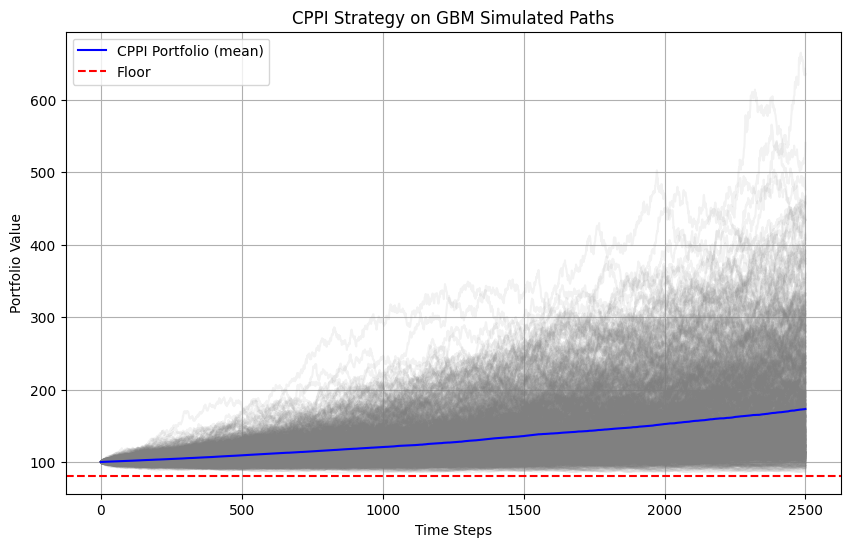

In [34]:
# Simulation parameters
n_years = 10
n_scenarios = 1000
mu = 0.07
sigma = 0.15
steps_per_year = 250
s_0 = 100

# CPPI strategy parameters
floor = 80
multiplier = 2

# Simulate GBM paths
gbm_sim = gbm(n_years=n_years, n_scenarios=n_scenarios, mu=mu, sigma=sigma, steps_per_year=steps_per_year, s_0=s_0)

# Apply CPPI strategy
cppi_portfolio = cppi(gbm_sim, floor=floor, multiplier=multiplier)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cppi_portfolio, alpha=0.1, color='grey')
plt.plot(cppi_portfolio.mean(axis=1), label='CPPI Portfolio (mean)', color='blue')
plt.axhline(y=floor, color='red', linestyle='--', label='Floor')
plt.title('CPPI Strategy on GBM Simulated Paths')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
(avg_return(cppi_portfolio)*100).describe()

count    1000.000000
mean        4.149187
std         2.601900
min        -1.426868
25%         2.024848
50%         3.844416
75%         6.146423
max        11.669429
dtype: float64

In [36]:
(avg_volatility(cppi_portfolio) * 100).describe()

count    1000.000000
mean       10.172103
std         2.407936
min         3.736226
25%         8.381870
50%        10.252632
75%        12.228592
max        14.790699
dtype: float64